In [4]:
# How VAE works
# An Encoder randomly samples a point z from the latent normaldistribution thats assumed to generate the inputimage via
# z_mean and z_variance
# then we randomly sample a point via z = z_mean + exp(z_log_variance) + epsilon
# decoder convert z to an image

In [5]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28,28,1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# maps the dense layer to a plane to get mean

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Using TensorFlow backend.


In [6]:
def sampling(args):
    z_mean, z_log_var =args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                             mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var)* epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [7]:
# input is z shape
decoder_input = layers.Input(K.int_shape(z)[1:])

# upsample
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32,3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(1,3, padding='same', activation='sigmoid')(x)

# our decoder model
decoder = Model(decoder_input, x)

# then we apply it to z
z_decoded = decoder(z)

In [8]:
# The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, we set up 
# the loss by writing a custom layer with internally leverages the built-in `add_loss` layer method to create an arbitrary loss.

class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x,z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss,inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [9]:
from keras.datasets import fashion_mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train,_),(x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') /255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

W0414 11:20:20.722733  9444 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0414 11:20:23.474753  9444 deprecation_wrapper.py:119] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 38s 639us/step - loss: 32.1981 - val_loss: 0.3400
Epoch 2/10
60000/60000 [==============================] - 37s 618us/step - loss: 0.3358 - val_loss: 0.3351
Epoch 3/10
60000/60000 [==============================] - 35s 582us/step - loss: 0.3319 - val_loss: 0.3319
Epoch 4/10
60000/60000 [==============================] - 34s 560us/step - loss: 0.3298 - val_loss: 0.3302
Epoch 5/10
60000/60000 [==============================] - 34s 570us/step - loss: 0.3283 - val_loss: 0.3311
Epoch 6/10
60000/60000 [==============================] - 36s 594us/step - loss: 0.3272 - val_loss: 0.3284
Epoch 7/10
60000/60000 [==============================] - 36s 594us/step - loss: 0.3263 - val_loss: 0.3280
Epoch 8/10
60000/60000 [==============================] - 35s 589us/step - loss: 0.3257 - val_loss: 0.3293
Epoch 9/10
60000/60000 [==============================] - 36s 592us/step - loss: 0.3251 - val

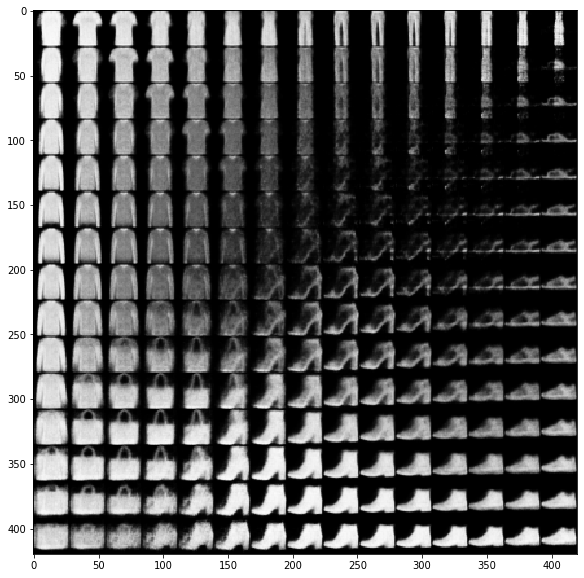

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()